<a href="https://colab.research.google.com/github/krdeepak39/Deep-learning-model/blob/main/Subtheme_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter

In [2]:
# Download NLTK data
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
path= 'drive/MyDrive/Colab Notebooks/Evaluation-dataset.csv'

In [4]:
# Load the CSV file
df = pd.read_csv(path)

In [5]:
def remove_empty(text):
    return [lab for lab in text if lab != '']

def remove_space(text):
    return [lab.strip() for lab in text]

In [6]:
columns = ['text']
labels = []
for idx in range(1, 16):
    name = 'label_' + str(idx)
    labels.append(name)
    columns.append(name)

# Read the CSV file with the correct number of expected columns
df = pd.read_csv(path, names=columns)  # Set column names during reading
df.columns = columns
df['target'] = df[labels].values.tolist()
df['target'] = df['target'].map(remove_empty)

df =  df[['text','target']]
df["target_counts"] = df["target"].apply(lambda label: len(label))
print("There are {} Rows in Data".format(df.shape[0]))

There are 10132 Rows in Data


<ipython-input-6-0a1b4e349a2b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target_counts"] = df["target"].apply(lambda label: len(label))


In [7]:
df.head()

,text,target,target_counts
0,Tires where delivered to the garage of my choi...,"[garage service positive, ease of booking posi...",15
1,"Easy Tyre Selection Process, Competitive Prici...","[garage service positive, value for money posi...",15
2,Very easy to use and good value for money.,"[value for money positive, nan, nan, nan, nan,...",15
3,Really easy and convenient to arrange,"[ease of booking positive, nan, nan, nan, nan,...",15
4,It was so easy to select tyre sizes and arrang...,"[location positive, value for money positive, ...",15


In [8]:
def clean_list(lst):
    if isinstance(lst, list):
        return [word for word in lst if pd.notna(word)]
    else:
        return lst


In [9]:
df['target'] = df['target'].apply(clean_list)

print("Original DataFrame:")
print(df)


Original DataFrame:
                                                    text  \
0      Tires where delivered to the garage of my choi...   
1      Easy Tyre Selection Process, Competitive Prici...   
2             Very easy to use and good value for money.   
3                  Really easy and convenient to arrange   
4      It was so easy to select tyre sizes and arrang...   
...                                                  ...   
10127  I ordered the wrong tyres, however [REDACTED] ...   
10128  Good experience, first time I have used [REDAC...   
10129  I ordered the tyre I needed on line, booked a ...   
10130  Excellent service from point of order to fitti...   
10131  Seamless, well managed at both ends. I would r...   

                                                  target  target_counts  
0      [garage service positive, ease of booking posi...             15  
1      [garage service positive, value for money posi...             15  
2                             [value 

In [10]:
df.head()

,text,target,target_counts
0,Tires where delivered to the garage of my choi...,"[garage service positive, ease of booking posi...",15
1,"Easy Tyre Selection Process, Competitive Prici...","[garage service positive, value for money posi...",15
2,Very easy to use and good value for money.,[value for money positive],15
3,Really easy and convenient to arrange,[ease of booking positive],15
4,It was so easy to select tyre sizes and arrang...,"[location positive, value for money positive, ...",15


In [11]:
df.isnull().values.any()


False

In [12]:
print("Number of Unique labels - {}".format(len(df.target.explode().unique())))

Number of Unique labels - 107


In [13]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 1)
pd.DataFrame.from_dict(dict(df.target.explode().value_counts()),orient = 'index',columns = ['Count'])

,Count
value for money positive,4780
garage service positive,2031
ease of booking positive,1187
location positive,1063
length of fitting positive,657
delivery punctuality positive,453
tyre quality positive,434
garage service negative,423
change of date negative,277
wait time positive,274


In [14]:

def get_noisy_labels(df):
    noisy_labels = []
    for label,count in Counter(df.target.explode()).items():
        if count < 5:
            if 'positive' not in label.split():
                if 'negative' not in label.split():
                    noisy_labels.append(label)
    return noisy_labels

# to remove nosiy labels from the dataframe
def remove_noisy_labels(df):
    #print("Removing noisy labels...")
    noisy_labels = get_noisy_labels(df)
    print("Number of Noisy Labels - {}".format(len(noisy_labels)))
    for i in range(len(df)):
        for nLabel in noisy_labels:
            if nLabel in df.iloc[i,1]:
                df.iloc[i,1].remove(nLabel)

    # to remove datapoints that doesn't have any labels
    df = df[df["target"].str.len() != 0]

    return df

df = remove_noisy_labels(df)

Number of Noisy Labels - 44


In [15]:
print("Number of Unique labels after removing noisy labels - {}".format(len(df.target.explode().unique())))

Number of Unique labels after removing noisy labels - 62


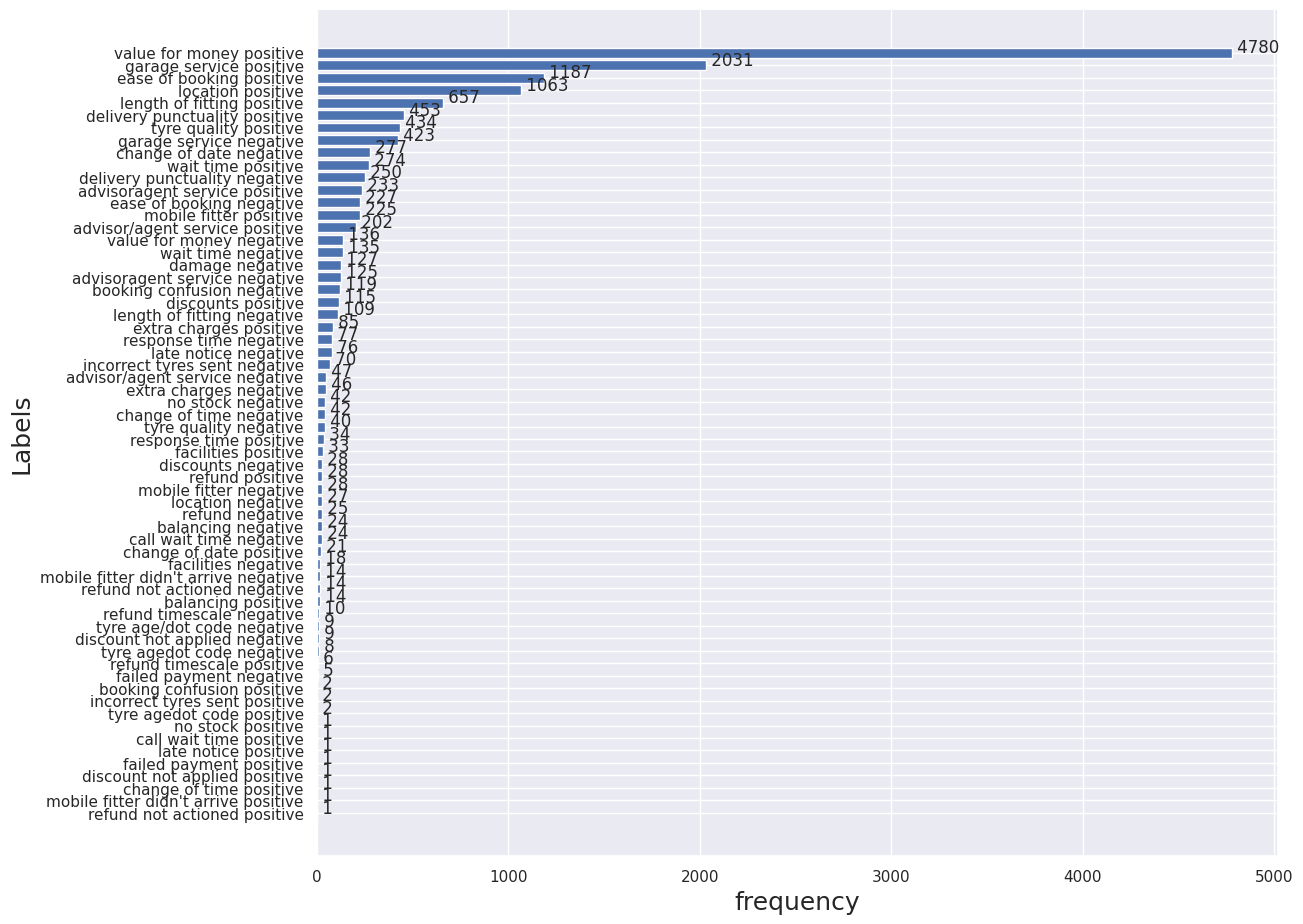

In [16]:
d = dict(Counter(df.target.explode()))
d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}

sns.set(rc={'figure.figsize':(12.4,11.00)})
plt.barh(range(len(d)), d.values(), align='center')
plt.yticks(range(len(d)), d.keys())
plt.xlabel('frequency', fontsize=18)
plt.ylabel('Labels', fontsize=18)

for index, value in enumerate(d.values()):
    plt.text(value, index, ' '+str(value))

plt.show()


In [17]:
def replace_label(df, src, trg):
    def replace(texts):
        return [lab if lab != src else trg for lab in texts]

    df['target'] = df['target'].map(replace)

def combine_labels(df,min_samples = 100):
    label_counts = df.target.explode().value_counts()
    label_names = label_counts.index

    fewer_labels = []
    for i,label in enumerate(label_names):
        if label_counts[i] < min_samples:
            fewer_labels.append(label)

    def replace_fewer(labels):
        fewers = []
        for label in labels:
            sentiment = label.split(' ')[-1]
            if label in fewer_labels:
                fewers.append(' '.join(['extra',sentiment]))
            else:
                fewers.append(label)

        return fewers

    df['target'] = df['target'].map(replace_fewer)

    return df

replace_label(df, 'advisor/agent service positive','advisoragent service positive')
replace_label(df, 'advisor/agent service negative','advisoragent service negative')
replace_label(df, 'tyre age/dot code negative','tyre agedot code negative')

df = combine_labels(df)

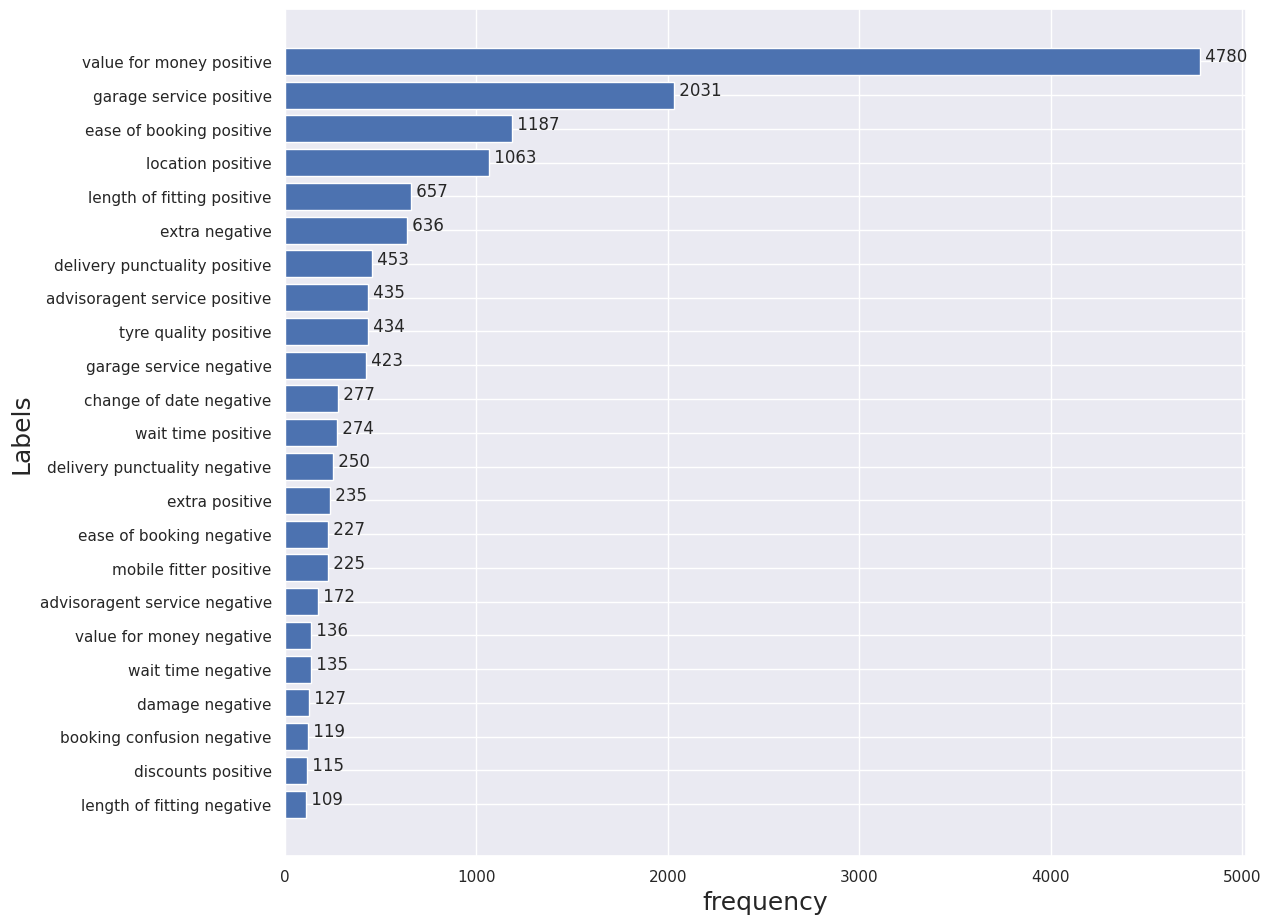

In [18]:
d = dict(Counter(df.target.explode()))
d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}

sns.set(rc={'figure.figsize':(12.4,11.00)})
plt.barh(range(len(d)), d.values(), align='center')
plt.yticks(range(len(d)), d.keys())
plt.xlabel('frequency', fontsize=18)
plt.ylabel('Labels', fontsize=18)

for index, value in enumerate(d.values()):
    plt.text(value, index, ' '+str(value))

plt.show()

In [19]:
print("Number of Unique Labels after all processing - {}".format(len(d)))

Number of Unique Labels after all processing - 23


In [20]:
print("No. of Rows after removing datapoint with 0 labels and noisy labels - {}".format(df.shape[0]))


No. of Rows after removing datapoint with 0 labels and noisy labels - 8125


In [21]:
udf = df[df.target.apply(lambda x: x == ['value for money positive'])]
print("No. of rows with only 'value for money positive' as Label - {} ".format(udf.shape[0]))


No. of rows with only 'value for money positive' as Label - 2143 


In [22]:
udf = df[df.target.apply(lambda x: x == ['value for money positive','garage service positive'])]
print("No. of rows with both 'value for money positive' and 'garage service positive' as Label - {} ".format(udf.shape[0]))

No. of rows with both 'value for money positive' and 'garage service positive' as Label - 232 


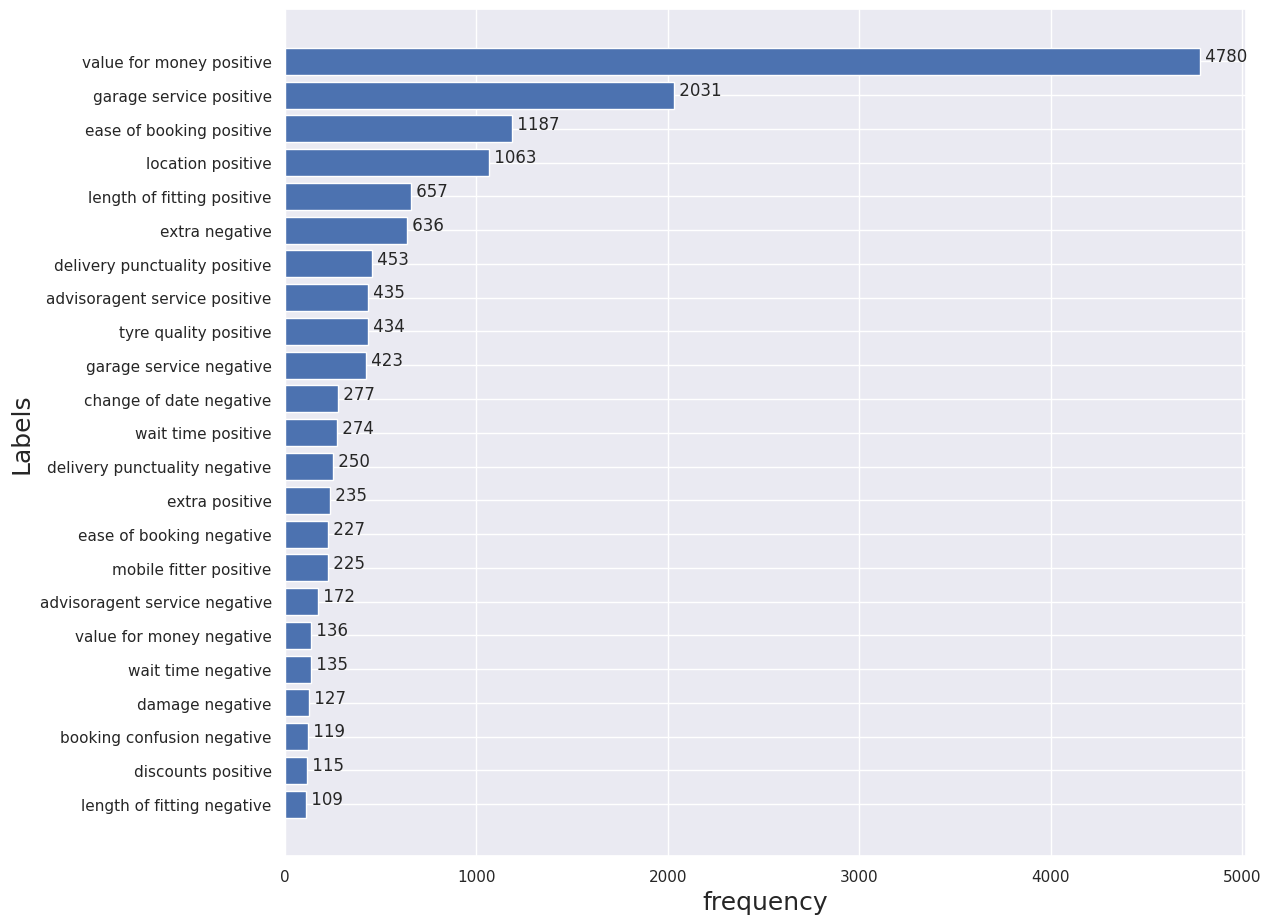

In [23]:
d = dict(Counter(df.target.explode()))
d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}

sns.set(rc={'figure.figsize':(12.4,11.00)})
plt.barh(range(len(d)), d.values(), align='center')
plt.yticks(range(len(d)), d.keys())
plt.xlabel('frequency', fontsize=18)
plt.ylabel('Labels', fontsize=18)

for index, value in enumerate(d.values()):
    plt.text(value, index, ' '+str(value))

plt.show()

In [24]:
labels = df['target']

In [25]:
def extract_labels(sentences, labels):
    label_sentences = {label: [] for label in labels}
    for sentence in sentences:
        for label in labels:
            if label in sentence.lower():
                label_sentences[label].append(sentence)
    return label_sentences

In [26]:
def predict_sentiment(sentences, model, tokenizer, max_len):
    results = {}
    for label, label_sentences in sentences.items():
        if label_sentences:
            sentence_str = " ".join(label_sentences)
            sequences = tokenizer.texts_to_sequences([sentence_str])
            padded = pad_sequences(sequences, maxlen=max_len)
            prediction = model.predict(padded)
            sentiment = 'Positive' if prediction >= 0.5 else 'Negative'
            results[label] = sentiment
    return results

In [27]:
texts = df['text'].values
target = df['target'].values

In [28]:
from sklearn.model_selection import train_test_split
vocab_size = 10000
max_len = 100

x_train, x_test, y_train, y_test = train_test_split(texts, target, test_size=0.2, random_state=42)
# Tokenize the text data
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(x_train) # Fit the tokenizer on the training data

# Convert text to sequences of integers
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Pad the sequences
x_train = pad_sequences(x_train_seq, maxlen=max_len)
x_test = pad_sequences(x_test_seq, maxlen=max_len)


In [29]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [30]:
def convert_labels(y_train):
    label_map = {'positive': 1, 'negative': 0}
    cleaned_y_train = []

    for sublist in y_train:
        cleaned_sublist = []
        for item in sublist:
            if isinstance(item, str):
                sentiment = item.split()[-1]
                if sentiment in label_map:
                    cleaned_sublist.append(label_map[sentiment])
                else:
                    cleaned_sublist.append(0)  # Default value if sentiment is not found
            else:
                cleaned_sublist.append(0)  # Default value for non-string items
        cleaned_y_train.append(cleaned_sublist[0] if cleaned_sublist else 0)  # Only take the first sentiment in case of multiple sentiments

    return np.array(cleaned_y_train)

cleaned_y_train = convert_labels(y_train)
print(cleaned_y_train)



[0 0 1 ... 1 1 1]


In [31]:
def convert_labels(y_test):
    label_map = {'positive': 1, 'negative': 0}
    cleaned_y_test = [] # This list will hold the cleaned labels

    for sublist in y_test:
        cleaned_sublist = []
        for item in sublist:
            if isinstance(item, str):
                sentiment = item.split()[-1]
                if sentiment in label_map:
                    cleaned_sublist.append(label_map[sentiment])
                else:
                    cleaned_sublist.append(0)  # Default value if sentiment is not found
            else:
                cleaned_sublist.append(0)  # Default value for non-string items
        cleaned_y_test.append(cleaned_sublist[0] if cleaned_sublist else 0)  # Only take the first sentiment in case of multiple sentiments

    return np.array(cleaned_y_test)

cleaned_y_test = convert_labels(y_test) # Assign the result to cleaned_y_test
print(cleaned_y_test)

[1 1 1 ... 1 1 1]


In [32]:
# Build the model
def build_model(vocab_size, max_len):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [33]:
model = build_model(vocab_size, max_len)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(x_train,cleaned_y_train, epochs=4, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
163/163 [==============================] - 58s 334ms/step - loss: 0.2841 - accuracy: 0.8902 - val_loss: 0.2216 - val_accuracy: 0.8954
Epoch 2/10
163/163 [==============================] - 54s 333ms/step - loss: 0.1546 - accuracy: 0.9433 - val_loss: 0.2221 - val_accuracy: 0.9154
Epoch 3/10
163/163 [==============================] - 51s 316ms/step - loss: 0.1049 - accuracy: 0.9631 - val_loss: 0.2243 - val_accuracy: 0.9138
Epoch 4/10
163/163 [==============================] - 51s 313ms/step - loss: 0.0759 - accuracy: 0.9769 - val_loss: 0.2670 - val_accuracy: 0.9146


In [34]:
test_loss, test_acc = model.evaluate(x_test, cleaned_y_test)
print(f'Test Accuracy: {test_acc:.4f}')

51/51 [==============================] - 2s 35ms/step - loss: 0.2153 - accuracy: 0.9071
Test Accuracy: 0.9071


In [35]:
index_to_check = 202  # You can choose any index from the test set

# Get the corresponding tokenized input
input_sequence = x_test[index_to_check]

# Convert tokenized input back to text
input_text = tokenizer.sequences_to_texts([input_sequence])[0] # Decode the tokenized sequence
print(f"The input text is: {input_text}")

# Preprocess the input text (this part remains the same)
sequence = tokenizer.texts_to_sequences([input_text])
padded_sequence = pad_sequences(sequence, maxlen=max_len)

# Make predictions (this part remains the same)
predictions = model.predict(padded_sequence)[0]

# Map predictions to positive or negative sentiment based on threshold (e.g., 0.5)
threshold = 0.5
sentiments = ['Negative' if pred < threshold else 'Positive' for pred in predictions]

# Print the result
print(f"The predicted sentiment for the input text is: {sentiments}")

The input text is: tyres by redacted excellent tyres and value
1/1 [==============================] - 0s 325ms/step
The predicted sentiment for the input text is: ['Positive']


In [36]:
# Tokenizer for the text data
tokenizer = Tokenizer(num_words=vocab_size)
# Assuming 'original_texts' is the list of raw text data before numerical conversion
tokenizer.fit_on_texts(texts)

In [37]:
label_sentiments_all = []

for index, row in df.iterrows():
    try:
        review_text = row['text']
        sentences = sent_tokenize(review_text)
        label_sentences = extract_labels(sentences, labels)
        label_sentiments = predict_sentiment(label_sentences)
        label_sentiments_all.append(label_sentiments)
        print(label_sentiments) # Print label sentiment for each row
    except:
        pass

all_labels = [label for sublist in df['target'] for label in sublist]
labels = list(set(all_labels))
print(labels) # Print the extracted labels



['advisoragent service negative', 'wait time negative', 'garage service positive', 'location positive', 'garage service negative', 'advisoragent service positive', 'wait time positive', 'extra negative', 'length of fitting negative', 'delivery punctuality negative', 'length of fitting positive', 'ease of booking positive', 'ease of booking negative', 'discounts positive', 'mobile fitter positive', 'value for money positive', 'damage negative', 'value for money negative', 'extra positive', 'delivery punctuality positive', 'tyre quality positive', 'change of date negative', 'booking confusion negative']


In [38]:
for idx, sentiments in enumerate(label_sentiments_all):
    print(f"Sentiments for Review {idx+1}:")
    for label, sentiment in sentiments.items():
        print(f"{label}: {sentiment}")

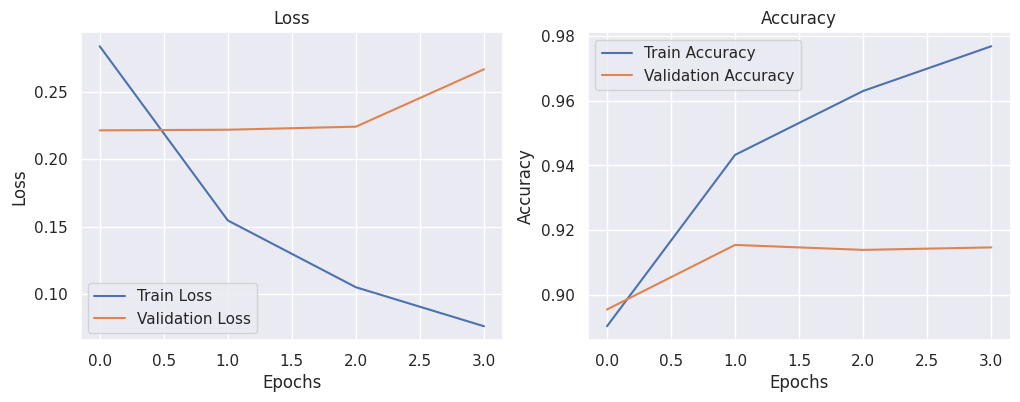

In [39]:

# Visualization of training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()